## A column generation algorithm for the $p$-median problem (PMP) [1]

Given a graph $G = (V,E)$...

$$
  \begin{align}
    \min & \sum\limits_{i \in S}\sum\limits_{j \in V} d_{ij} x_{ij} \\
    \text{subject to} & \nonumber \\
    & \sum\limits_{j \in V} x_{ij} = 1, & \forall i \in V \\
    & \sum\limits_{j \in V} x_{jj} = p, \\
    & x_{ij} \leq x_{jj}, & \forall i, j \in V \\
    & x_{ij} \in \{0, 1\}, & \forall i, j \in V.
  \end{align}
$$

...

In [13]:
import csv
import random
import sys

import numpy as np
import gurobipy as gp
from gurobipy import GRB
from matplotlib import pyplot as plt

#### Read data

In [14]:
# Distance matrix
distMtx = numpy.array([row[1:] for row in list(csv.reader(open("./data/scotland_yard_adj_mtx.csv", "r"), delimiter=","))[1:]]).astype("int")

print(distMtx)

EPS = 0.00001

# Number of vertices
n = len(distMtx)

# number of medians
p = 3

[[ 0  7 10 17 13 29 17 25 20 17 19 23 33 31 24]
 [ 7  0 15 16 12 28 22 24 15 11 12 16 31 25 17]
 [10 15  0  9  7 21 15 17 12 16 19 23 25 23 24]
 [17 16  9  0  8 14  8 10 11 15 20 24 18 16 24]
 [13 12  7  8  0 18 14 14  9 11 14 18 22 20 19]
 [29 28 21 14 18  0 16  6  7 22 17 13 10  4 12]
 [17 22 15  8 14 16  0 12 17 21 26 27 20 18 26]
 [25 24 17 10 14  6 12  0 11 21 21 17 10  8 16]
 [20 15 12 11  9  7 17 11  0  6 11  8 15  5  7]
 [17 11 16 15 11 22 21 21  6  0  7 11 26 20 12]
 [19 12 19 20 14 17 26 21 11  7  0  6 21 15  7]
 [23 16 23 24 18 13 27 17  8 11  6  0 17 11  3]
 [33 31 25 18 22 10 20 10 15 26 21 17  0 12 11]
 [31 25 23 16 20  4 18  8  5 20 15 11 12  0 10]
 [24 17 24 24 19 12 26 16  7 12  7  3 11 10  0]]


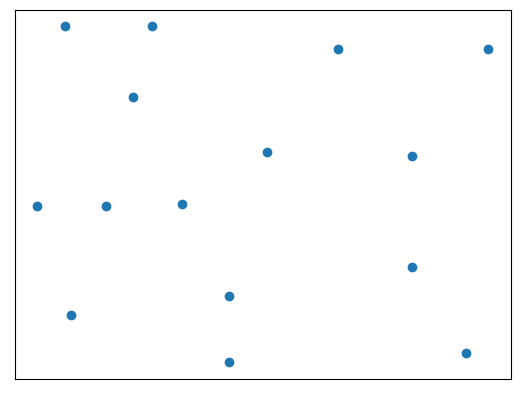

In [15]:
# Vertices coordinates (x,y)
coords = numpy.array(list(csv.reader(open("./data/coords.csv", "r"), delimiter=","))).astype("float")

x1, y1 = coords.T
plt.scatter(x1, y1)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

#### Generate an initial set of columns (clusters)

In [18]:
################################################################################
# Compute clusters' costs
################################################################################
def computeClusterCost(cluster):
    # find best median
    median = -1
    minDist = float('inf')
    for i in range(len(cluster)):
        if (cluster[i] == 1):
            dist = 0
            for j in range(len(cluster)):
                if (cluster[j] == 1):
                    dist += distMtx[i][j]
            if (dist < minDist):
                minDist = dist
                median = i
    
    return median, minDist
    
# Initial 2 * n random clusters
initClusters = [[random.randint(0, 1) for i in range(n)] for j in range(2 * n)]
initClustersCosts = [computeClusterCost(cluster)[1] for cluster in initClusters]
initClusters = numpy.array(initClusters)

# Print initial clusters
print(np.transpose(initClusters))
print(initClustersCosts)

[[0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0]
 [1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0]
 [0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0]
 [1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0]
 [1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1]
 [1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0]
 [0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0]
 [0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0]
 [0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1]
 [0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0 0]
 [1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1]
 [0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1]
 [1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1]
 [1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0]]
[62, 90, 96, 73, 75, 135, 65, 84, 76, 87, 116, 133, 84

### Restricted master problem (RMP)

$$
  \begin{align}
    \min & \sum\limits_{j = 1}^{m} c_j y_j \\
    \text{subject to} & \nonumber \\
    & \sum\limits_{j = 1}^{m} a_{ij} y_j \geq 1, & \forall i \in V, \\
    & \sum\limits_{j = 1}^{m} y_j = p, \\
    & y_{j} \in [0, 1], & j = 1, \dots, m.
  \end{align}
$$

#### Building our RMP model 

In [19]:
# Model RMP
rmpModel = gp.Model("rmp")

# Create decision variables y_j
y = rmpModel.addVars(len(initClusters), obj=initClustersCosts, name="y")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-13


#### Adding constraints

In [20]:
# Covering constraints
coverConstrs = rmpModel.addConstrs((gp.quicksum(initClusters[i][j] * y[i]
                                                for i in range(len(initClusters))) >= 1 
                                                for j in range(n)), name="c1_")

# p-medians constraint
pConstr = rmpModel.addConstr(gp.quicksum(y[i] for i in range(len(initClusters))) == p, name="c2_")

### Subproblem (pricing)

All columns $i$ $[a_{i1} \cdots a_{in} | 1]$ satisfying the following inequality can be added to the RMP:

$$
\begin{equation}
  \label{eq:rc}
  \min\limits_{a_{ij} \in \{0, 1\}}\left(\sum\limits_{j = 1}^n (d_{ij} - \pi_j)a_{ij}\right) - \pi_{n+1} < 0,
\end{equation}
$$
where coefficients $a{ij}$ are defined by
$$
\begin{equation*}
    a_{ij} = 
    \begin{cases}
        1, & \text{if } d_{ij} - \pi_j < 0 \\
        0, & \text{otherwise}.
    \end{cases}
\end{equation*}
$$

#### Retrieving the dual costs

In [21]:
################################################################################
# Retrieve duals from the RMP
################################################################################
def retrieveDualCosts(coverConstrs, pConstr):
    duals = []
    for constr in coverConstrs.select():
        duals.append(constr.Pi)

    duals.append(pConstr.Pi)
    
    return duals

#### Generating columns

In [22]:
################################################################################
# Function to generate a new column to the RMP
################################################################################
def generateColumn(i, duals):
    rc = 0
    cluster = numpy.zeros(n)
    # RC of the n first constraints (cover constraints)
    for j in range(n):
        if (distMtx[i][j] - duals[j] < 0):
            cluster[j] = 1
            rc += distMtx[i][j] - duals[j]

    # RC of the p-medians constraint
    rc -= duals[n]
    
    # If negative RC, then compute cluster cost
    clusterCost = float('inf')
    if (rc < 0):
        clusterCost = computeClusterCost(cluster)[1]
    
    return cluster, clusterCost

################################################################################
# Add a column to the RMP
################################################################################
def appendNewColumn(cluster, clusterCost):
    
    # Create a new variable related to the new column
    new_y = rmpModel.addVar(obj=clusterCost, name="y_" + str(rmpModel.NumVars))
    
    # Add the new y's cover constrs coefficient (first |V| constraints)
    for i in range(n):
        if (cluster[i] == 1):
            rmpModel.chgCoeff(coverConstrs[i], new_y, 1)
    
    # Add the new y's p constraint (|V|th constraint)
    rmpModel.chgCoeff(pConstr, new_y, 1)
    
    return

################################################################################
# Generates and adds new columns to the RMP
################################################################################
def addNewColumns(duals):
    
    nbFound = 0
    for i in range(n):
        cluster, clusterCost =  generateColumn(i, duals)
        # If the column has negative RC, then add it to the RMP
        if (clusterCost < float('inf')):
            appendNewColumn(cluster, clusterCost)
            nbFound += 1

    print(" added " + str(nbFound) + " newcolumns", end='')
    return nbFound

#### Column generation main routine

In [23]:
# Solve the model for the first time
rmpModel.Params.OutputFlag = 0
rmpModel.optimize()
print("RMP initial ObjVal: %.2f\n" % rmpModel.ObjVal)

duals = retrieveDualCosts(coverConstrs, pConstr)

i = 0;
maxIter = 1000
print(f'CG({i}):', end='')
while (i < maxIter and addNewColumns(duals)):
    rmpModel.optimize()
    duals = retrieveDualCosts(coverConstrs, pConstr)
    i += 1
    print(", RMP ObjVal: %.2f" % rmpModel.ObjVal)
    print(f'CG({i}):', end='')
    
print(f'\n\nRMP # of variables: {rmpModel.NumVars}')

RMP initial ObjVal: 236.80

CG(0): added 15 newcolumns, RMP ObjVal: 126.00
CG(1): added 15 newcolumns, RMP ObjVal: 103.00
CG(2): added 15 newcolumns, RMP ObjVal: 94.00
CG(3): added 14 newcolumns, RMP ObjVal: 83.50
CG(4): added 13 newcolumns, RMP ObjVal: 69.00
CG(5): added 14 newcolumns, RMP ObjVal: 69.00
CG(6): added 7 newcolumns, RMP ObjVal: 69.00
CG(7): added 5 newcolumns, RMP ObjVal: 68.00
CG(8): added 3 newcolumns, RMP ObjVal: 67.00
CG(9): added 1 newcolumns, RMP ObjVal: 67.00
CG(10): added 0 newcolumns

RMP # of variables: 132


#### Imposing integrality on y variables

In [24]:
rmpModel.Params.OutputFlag = 1

# Change y vars to binary to solve the original PMP
for var in rmpModel.getVars():
    var.VType = GRB.BINARY
    
# Change the sense of cover constraints to partitioning constraints (<= to =)
for constr in rmpModel.getConstrs():
    constr.Sense = '='

Set parameter OutputFlag to value 1


### Solving the set partitioning PMP

$$
  \begin{align}
    \min & \sum\limits_{j = 1}^{2^n} c_j y_j \\
    \text{subject to} & \nonumber \\
    & \sum\limits_{j = 1}^{2^n} a_{ij} y_j = 1, & \forall i \in V, \\
    & \sum\limits_{j = 1}^{2^n} y_j = p, \\
    & y_{j} \in \{0, 1\}, & j = 1, \dots, 2^n.
  \end{align}
$$

In [25]:
# Solve it again, but now as an integer linear program (ILP)
rmpModel.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16 rows, 132 columns and 718 nonzeros
Model fingerprint: 0x135c0b5c
Variable types: 0 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 0 rows and 41 columns
Presolve time: 0.01s
Presolved: 16 rows, 91 columns, 391 nonzeros
Variable types: 0 continuous, 91 integer (91 binary)
Found heuristic solution: objective 67.0000000

Root relaxation: cutoff, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        67.00000   67.00000  0.00%     -    0s

Explored 1 nodes (24 simplex iterations) in 0.02 seconds 

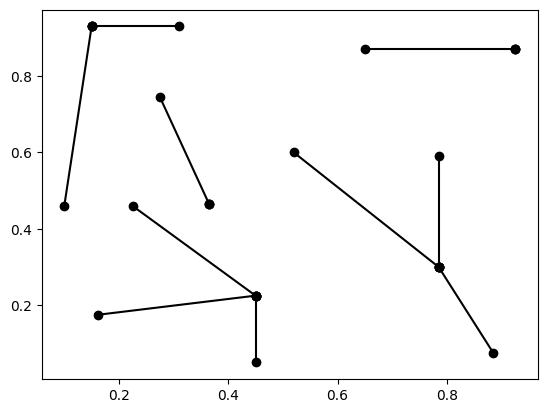

In [26]:
# Dirty code to print the ILP solution
for y in rmpModel.getVars():
    if y.X > EPS: 
        cluster = numpy.zeros(n)
        for i in range(n):
            if (rmpModel.getCoeff(coverConstrs[i], y)):
                cluster[i] = 1
        median = computeClusterCost(cluster)[0]
        for i in range(n):
            if (rmpModel.getCoeff(coverConstrs[i], y) == 1):
                plt.plot([x1[median], x1[i]], [y1[median], y1[i]], color='black', marker='o')
            
plt.show()